<a href="https://colab.research.google.com/github/Hemang-sen/UCS551_SummerSem_HemangSen-102216064-/blob/main/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### QUESTION 1

In [1]:
file_path="/content/drive/MyDrive/price_paid_records.csv"

In [2]:
import pandas as pd
from datetime import datetime, timedelta
cutoff_date = datetime.now() - timedelta(days=730)
df_check = pd.read_csv(file_path, nrows=5)
print("Column names in your file:", df_check.columns.tolist())

Column names in your file: ['Transaction unique identifier', 'Price', 'Date of Transfer', 'Property Type', 'Old/New', 'Duration', 'Town/City', 'District', 'County', 'PPDCategory Type', 'Record Status - monthly file only']


In [3]:
cutoff_date = pd.Timestamp("2016-01-01")
chunks = pd.read_csv(
    file_path,
    usecols=['Price', 'Property Type', 'Town/City', 'Date of Transfer'],
    parse_dates=['Date of Transfer'],
    chunksize=100_000,
    low_memory=False
)
filtered_chunks = []
for chunk in chunks:
    chunk = chunk[chunk['Date of Transfer'] >= cutoff_date]
    filtered_chunks.append(chunk)

df_selected = pd.concat(filtered_chunks)
print("Shape of filtered dataset:", df_selected.shape)
print(df_selected.head())

Shape of filtered dataset: (1407656, 4)
            Price Date of Transfer Property Type Town/City
21081692  1860000       2016-03-21             F    LONDON
21081693   385000       2016-04-15             F    LONDON
21081694   540000       2016-04-21             F    LONDON
21081695  2300000       2016-03-31             T    LONDON
21081696  2650000       2016-03-31             F    LONDON


In [4]:
df_dates = pd.read_csv(file_path, usecols=['Date of Transfer'], parse_dates=['Date of Transfer'])
print("Min date:", df_dates['Date of Transfer'].min())
print("Max date:", df_dates['Date of Transfer'].max())

Min date: 1995-01-01 00:00:00
Max date: 2017-06-29 00:00:00


In [7]:
!pip install -q rapids
import cudf
from cuml.preprocessing import LabelEncoder
gdf = cudf.DataFrame.from_pandas(df_selected)
median_price = gdf['Price'].median()
gdf['target'] = (gdf['Price'] >= median_price).astype('int32')

cat_cols = ['Property Type', 'Town/City']
for col in cat_cols:
    le = LabelEncoder()
    gdf[col] = le.fit_transform(gdf[col])

In [33]:
from cuml.ensemble import RandomForestClassifier
from cuml.model_selection import train_test_split
import time

features = ['Property Type', 'Town/City']
X = gdf[features]
y = gdf['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

start_gpu = time.time()
clf_gpu = RandomForestClassifier(n_estimators=100, max_depth=5)
clf_gpu.fit(X_train, y_train)
gpu_time = time.time() - start_gpu

print(f"GPU Random Forest trained in {gpu_time:.4f} seconds")

GPU Random Forest trained in 2.5762 seconds


In [14]:
from cuml.metrics import accuracy_score
from sklearn.metrics import precision_score, confusion_matrix
y_pred = clf_gpu.predict(X_test)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test.to_pandas(), y_pred.to_pandas())
cm = confusion_matrix(y_test.to_pandas(), y_pred.to_pandas())

print("Accuracy:", acc)
print("Precision:", precision)
print("Confusion Matrix:\n", cm)


Accuracy: 0.5891677737236023
Precision: 0.6781531686506571
Confusion Matrix:
 [[116591  23387]
 [ 92275  49278]]


In [20]:
from sklearn.ensemble import RandomForestClassifier as SkRF
from sklearn.model_selection import train_test_split as sk_split
import time
pdf = gdf.to_pandas()
features = ['Property Type', 'Town/City']
X = pdf[features]
y = pdf['target']
X_train, X_test, y_train, y_test = sk_split(X, y, test_size=0.2)
start_cpu = time.time()
clf_cpu = SkRF(n_estimators=100, max_depth=5)
clf_cpu.fit(X_train, y_train)
cpu_time = time.time() - start_cpu
print(f"CPU RF trained in {cpu_time:.4f} seconds")
print(f"GPU RF trained in {gpu_time:.4f} seconds")

CPU RF trained in 66.4541 seconds
GPU RF trained in 2.6917 seconds


### QUESTION 2

In [34]:
features = ['Property Type', 'Town/City']
X = gdf[features]
y = gdf['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

start = time.time()
rf_gpu = RandomForestClassifier(n_estimators=100, max_depth=5)
rf_gpu.fit(X_train, y_train)
gpu_time = time.time() - start
print(f"Trained Random Forest with 100 trees in {gpu_time:.4f} seconds")

Trained Random Forest with 100 trees in 2.4752 seconds


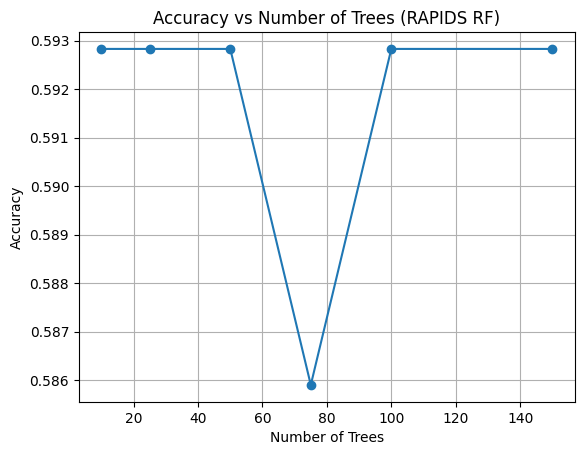

In [17]:
import matplotlib.pyplot as plt
tree_counts = [10, 25, 50, 75, 100, 150]
accuracies = []
for n in tree_counts:
    model = RandomForestClassifier(n_estimators=n, max_depth=5)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)
plt.plot(tree_counts, accuracies, marker='o')
plt.title("Accuracy vs Number of Trees (RAPIDS RF)")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

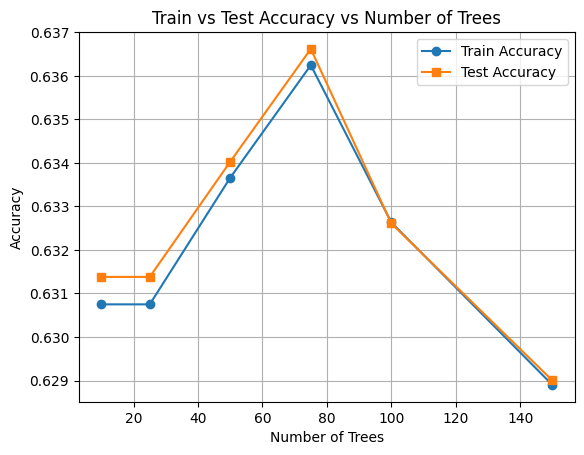

In [18]:
train_accuracies = []
test_accuracies = []

for n in tree_counts:
    model = RandomForestClassifier(n_estimators=n, max_depth=10)
    model.fit(X_train, y_train)

    acc_train = accuracy_score(y_train, model.predict(X_train))
    acc_test = accuracy_score(y_test, model.predict(X_test))

    train_accuracies.append(acc_train)
    test_accuracies.append(acc_test)

# Plot
plt.plot(tree_counts, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(tree_counts, test_accuracies, label='Test Accuracy', marker='s')
plt.title("Train vs Test Accuracy vs Number of Trees")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### QUESTION 3

In [21]:
from cuml.preprocessing import LabelEncoder
from cuml.cluster import KMeans
cat_cols = ['Property Type', 'Town/City']
for col in cat_cols:
    le = LabelEncoder()
    gdf[col] = le.fit_transform(gdf[col])
features = ['Price', 'Property Type', 'Town/City']
X = gdf[features]

kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(X)
labels_3 = kmeans_3.labels_
kmeans_5 = KMeans(n_clusters=5)
kmeans_5.fit(X)
labels_5 = kmeans_5.labels_

,0,1
21081692,1.545152e+06,29.684687
21081693,7.015210e+04,31.146706
21081694,2.251521e+05,30.993071
21081695,1.985152e+06,29.247635
21081696,2.335152e+06,28.901638


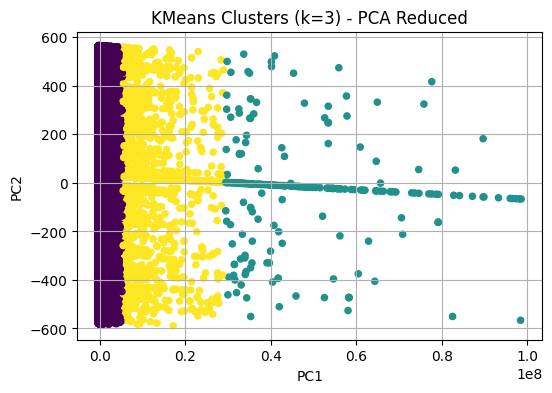

In [23]:
import matplotlib.pyplot as plt
from cuml.decomposition import PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)
display(X_2d.head())
X_2d_pdf = X_2d.to_pandas()
labels_np = labels_3.values_host
plt.figure(figsize=(6, 4))
plt.scatter(X_2d_pdf.iloc[:, 0], X_2d_pdf.iloc[:, 1], c=labels_np, cmap='viridis', s=20)
plt.title("KMeans Clusters (k=3) - PCA Reduced")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [28]:
from sklearn.metrics import silhouette_score
X_cpu = X.to_pandas()
labels_3_cpu = labels_3.to_pandas()
labels_3_cpu.index = X_cpu.index
sample_indices = X_cpu.sample(n=10000, random_state=42).index
X_sample = X_cpu.loc[sample_indices]
labels_sample = labels_3_cpu.loc[sample_indices]
silhouette_sample = silhouette_score(X_sample, labels_sample)
print("Sampled Silhouette Score (k=3):", silhouette_sample)

Sampled Silhouette Score (k=3): 0.978607823619873


### QUESTION 4

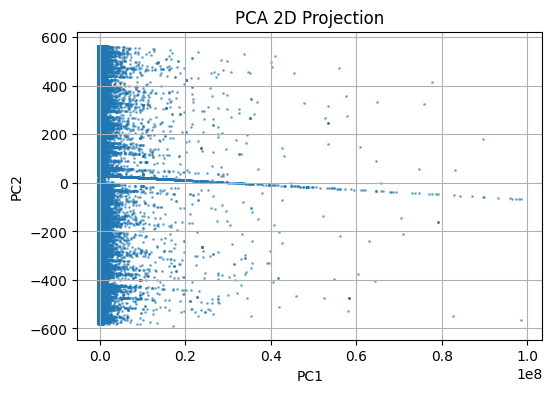

In [30]:
from mpl_toolkits.mplot3d import Axes3D
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

X_pca_2d_pdf = X_pca_2d.to_pandas()
plt.figure(figsize=(6, 4))
plt.scatter(X_pca_2d_pdf.iloc[:, 0], X_pca_2d_pdf.iloc[:, 1], s=1, alpha=0.5)
plt.title("PCA 2D Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

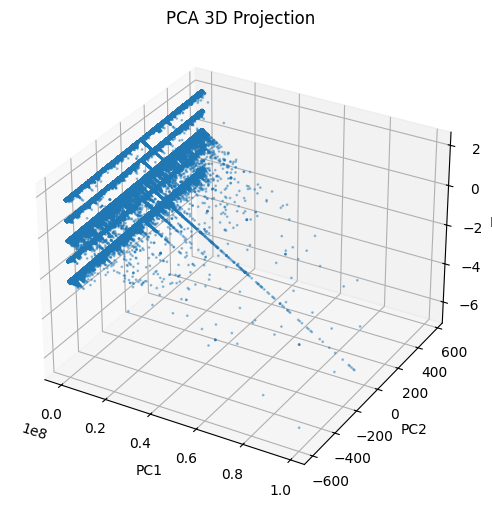

In [31]:
X_pca_3d_pdf = X_pca_3d.to_pandas()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca_3d_pdf.iloc[:, 0], X_pca_3d_pdf.iloc[:, 1], X_pca_3d_pdf.iloc[:, 2], s=1, alpha=0.4)
ax.set_title("PCA 3D Projection")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

[2025-07-13 15:54:15.890] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


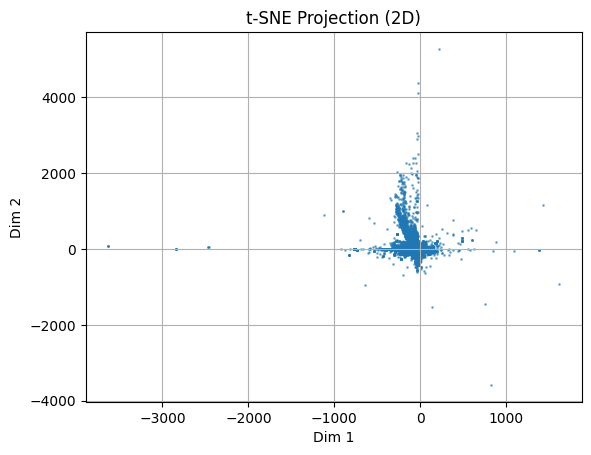

[2025-07-13 15:58:33.119] [CUML] [info] Building knn graph using nn descent


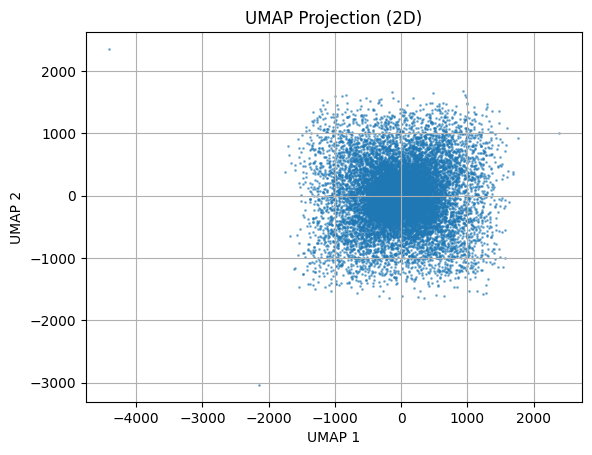

In [32]:
from cuml.manifold import TSNE
from cuml.manifold import UMAP
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X)
X_tsne_pdf = X_tsne.to_pandas()
plt.scatter(X_tsne_pdf.iloc[:, 0], X_tsne_pdf.iloc[:, 1], s=1, alpha=0.5)
plt.title("t-SNE Projection (2D)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()



umap = UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
X_umap = umap.fit_transform(X)
X_umap_pdf = X_umap.to_pandas()
plt.scatter(X_umap_pdf.iloc[:, 0], X_umap_pdf.iloc[:, 1], s=1, alpha=0.5)
plt.title("UMAP Projection (2D)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()